# AWS CTR Prediction:
#### 1. This script reads train data, user logs and impression data
#### 2. This script analyzes user logs and creates features from log information
#### 3. This script analyzes item infomation and creates features from them
#### 4. This script analyzes impression information and creates impression time related features
#### 5. This script merges all the information at user level
#### 6. This script implements H2O Auto ML method to perform logisitic modeling (is_click being the targe)

### File Reading & Merging

In [1]:
import os 
import pandas as pd
import numpy as np
import warnings
import functools
from scipy import stats
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

os.chdir(r"C:\important_files\hackathons")

In [99]:
#Reading the files
train=pd.read_csv("train.csv")
log=pd.read_csv("view_log.csv")
item=pd.read_csv("item_data.csv")

In [46]:
data=train.copy()

In [47]:
data.sort_values(by=['user_id','impression_id']).head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
104312,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,0,207,old,0,0
24562,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,2,190,intermediate,0,0
49515,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,2,190,intermediate,0,0
78666,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,2,190,intermediate,0,0
54202,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,2,190,intermediate,0,0


### Analyzing user logs

In [5]:
log.sort_values(by=['user_id']).head()

,server_time,device_type,session_id,user_id,item_id
1355945,2018-11-11 10:23:00,android,143955,0,120442
164774,2018-10-18 14:47:00,android,268465,0,44459
2761690,2018-12-06 06:33:00,android,144465,0,126865
164729,2018-10-18 14:46:00,android,268465,0,44459
164700,2018-10-18 14:46:00,android,268465,0,44459


##### Does an user has one session or multiple sessions ?
##### Does an user browses for 1 product or multiple products n a single session?
##### What is the average duration of a session for an user ?
##### What is the total items per user ?

Text(0.5, 1.0, 'Number of Sessions Per User')

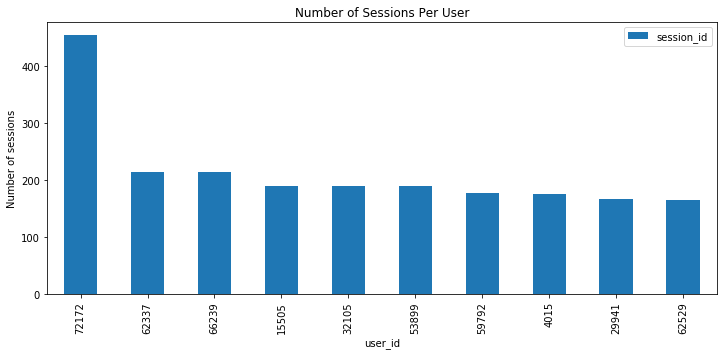

In [48]:
#total number of sessions per user
g=log.groupby(['user_id']).agg({'session_id':'nunique'})
g.sort_values(by=['session_id'],ascending=False).head(10).plot(kind='bar',figsize=(12,5))
plt.ylabel('Number of sessions')
plt.title('Number of Sessions Per User')

Text(0.5, 1.0, 'Number of items per session per user')

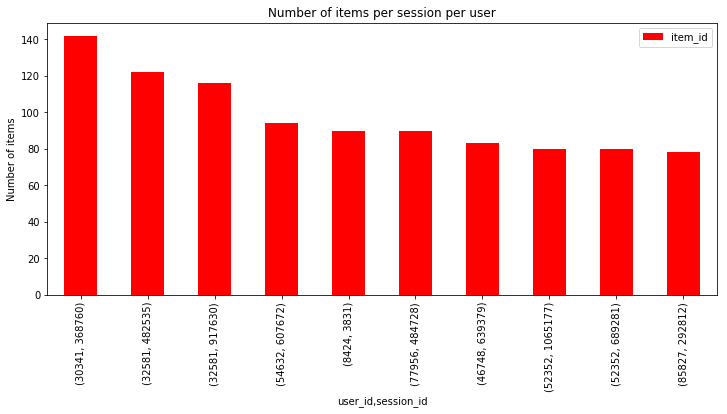

In [49]:
#total number of items per session 
h=log.groupby(['user_id','session_id']).agg({'item_id':'nunique'})
h.sort_values(by=['item_id'],ascending=False).head(10).plot(kind='bar',figsize=(12,5),color='red')
plt.ylabel('Number of items')
plt.title('Number of items per session per user')

In [50]:
#First and last time
a=log.groupby(['user_id','session_id'])['server_time'].nth(0).reset_index().rename(columns={'server_time':'First_server_time'})#First
b=log.groupby(['user_id','session_id'])['server_time'].nth(-1).reset_index().rename(columns={'server_time':'Last_server_time'})#Last
server=pd.merge(a,b,on=['user_id','session_id'])
print(server.head())
print(a.shape,b.shape,server.shape)

   user_id  session_id    First_server_time     Last_server_time
0        0       86373  2018-12-04 07:19:00  2018-12-04 07:19:00
1        0      143955  2018-11-11 10:09:00  2018-11-11 10:51:00
2        0      144465  2018-12-06 06:15:00  2018-12-06 06:33:00
3        0      191704  2018-12-07 20:32:00  2018-12-07 20:32:00
4        0      268465  2018-10-18 14:27:00  2018-10-18 14:47:00
(1014990, 3) (1014990, 3) (1014990, 4)


In [51]:
#Duration : difference between First_server_time and Last_server_time
server['Last_server_time']=pd.to_datetime(server['Last_server_time'])
server['First_server_time']=pd.to_datetime(server['First_server_time'])
server['server_duration_min']=(server['Last_server_time']-server['First_server_time']).astype('timedelta64[m]')
server.head()

,user_id,session_id,First_server_time,Last_server_time,server_duration_min
0,0,86373,2018-12-04 07:19:00,2018-12-04 07:19:00,0.0
1,0,143955,2018-11-11 10:09:00,2018-11-11 10:51:00,42.0
2,0,144465,2018-12-06 06:15:00,2018-12-06 06:33:00,18.0
3,0,191704,2018-12-07 20:32:00,2018-12-07 20:32:00,0.0
4,0,268465,2018-10-18 14:27:00,2018-10-18 14:47:00,20.0


Text(0.5, 1.0, 'Average duration in minutes per user')

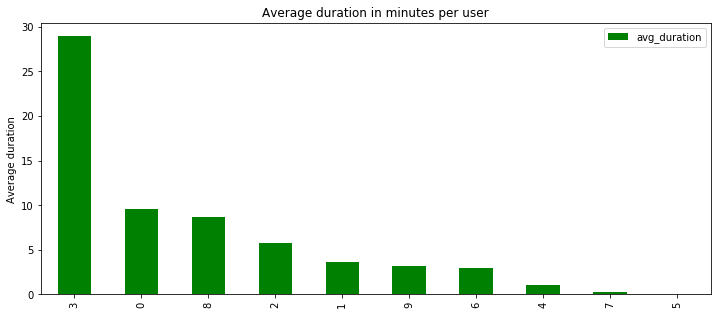

In [52]:
#Creating average duration per user
diff=server.groupby(['user_id'])['server_duration_min'].mean().reset_index().rename(columns={'server_duration_min':'avg_duration'})
i=diff[['user_id','avg_duration']].head(10)
i.sort_values(['avg_duration'],ascending=False).plot.bar(y='avg_duration',figsize=(12,5),color='green')
plt.ylabel('Average duration')
plt.title('Average duration in minutes per user')

In [53]:
#Merging table
m=log.groupby(['user_id']).agg({'session_id':'nunique'}).reset_index().rename(columns={'session_id':'Total_sessions_per_user'})
n=log.groupby(['user_id','session_id'])['item_id'].nunique().reset_index().rename(columns={'item_id':'Total_items_per_session_per_user'})
o=diff.rename(columns={'avg_duration':'avg_duration_per_user'})
j=log.groupby(['user_id'])['item_id'].nunique().reset_index().rename(columns={'item_id':'Total_items_per_user'})
n1=n.groupby(['user_id'])['Total_items_per_session_per_user'].mean().reset_index()
p=log.groupby(['user_id'])['device_type'].agg(lambda x: stats.mode(x)[0][0])
log_val=functools.reduce(functools.partial(pd.merge, on='user_id'), [m,n1,o,j,p])
log_val.head()

,user_id,Total_sessions_per_user,Total_items_per_session_per_user,avg_duration_per_user,Total_items_per_user,device_type
0,0,11,2.363636,9.545455,18,android
1,1,3,2.666667,3.666667,8,android
2,2,37,4.216216,5.729730,130,android
3,3,1,3.000000,29.000000,3,android
4,4,1,2.000000,1.000000,2,android


### Analyzing items

In [100]:
item.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [101]:
#For aggregating with respect to a user, user log data is merged
df_merge3=pd.merge(log[['user_id','item_id']],item,on='item_id')
df_merge3.sort_values(by='user_id').head(10)

,user_id,item_id,item_price,category_1,category_2,category_3,product_type
873322,0,44459,3776,14,29,199,7363
843347,0,126865,4736,1,36,203,9344
843522,0,126865,4736,1,36,203,9344
411809,0,1751,2227,14,61,159,1694
873319,0,44459,3776,14,29,199,7363
2094320,0,41184,1367,17,8,113,6318
48883,0,58320,1075,13,58,173,5358
134282,0,116073,4181,17,39,151,124
1193693,0,89373,2496,17,8,113,10025
134958,0,116073,4181,17,39,151,124


##### What is the average item price per user
##### How many unique category_1 products per user
##### How many unique category_2 products per user
##### How many unique category_3 products per user
##### How many unique Product_types per user
##### What is the average item price per category 1, category 2, category 3 per user
##### What is the average price per product type per user

Text(0.5, 1.0, 'Average item price per user')

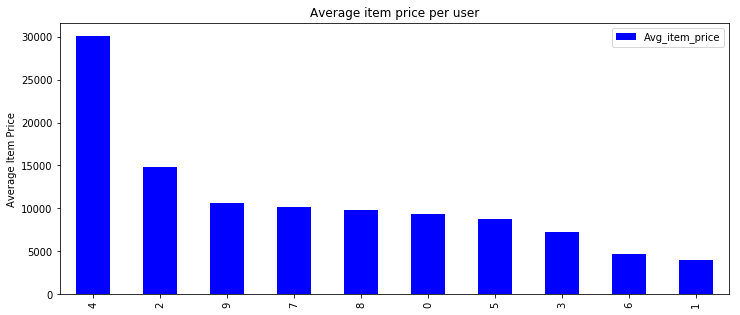

In [102]:
#Creating average price per user
price=df_merge2.groupby(['user_id'])['item_price'].mean().reset_index().rename(columns={'item_price':'Avg_item_price'})
i=price[['user_id','Avg_item_price']].head(10)
i.sort_values(['Avg_item_price'],ascending=False).plot.bar(y='Avg_item_price',figsize=(12,5),color='blue')
plt.ylabel('Average Item Price')
plt.title('Average item price per user')

In [103]:
#unique category_1,category_2,category_3 products per user
c1=df_merge3.groupby(['user_id'])['category_1'].nunique().reset_index().rename(columns={'category_1':'Total_category1_items'})
c2=df_merge3.groupby(['user_id'])['category_2'].nunique().reset_index().rename(columns={'category_2':'Total_category2_items'})
c3=df_merge3.groupby(['user_id'])['category_3'].nunique().reset_index().rename(columns={'category_3':'Total_category3_items'})
c4=df_merge3.groupby(['user_id'])['product_type'].nunique().reset_index().rename(columns={'product_type':'Total_products'})
c5=df_merge3.groupby(['user_id'])['item_price'].sum().reset_index().rename(columns={'item_price':'Total_item_price'})

item_val=functools.reduce(functools.partial(pd.merge, on='user_id'), [c1,c2,c3,c4,c5])
item_val.head()

,user_id,Total_category1_items,Total_category2_items,Total_category3_items,Total_products,Total_item_price
0,0,9,15,16,18,394618
1,1,7,7,7,8,31574
2,2,15,47,82,126,2443569
3,3,3,3,3,3,58059
4,4,2,2,2,2,60229


In [104]:
#Calculating products per price
item_val['Avg_price_per_cat1']=item_val['Total_item_price']/item_val['Total_category1_items']
item_val['Avg_price_per_cat2']=item_val['Total_item_price']/item_val['Total_category2_items']
item_val['Avg_price_per_cat3']=item_val['Total_item_price']/item_val['Total_category3_items']
item_val.head() # Item_val is created

,user_id,Total_category1_items,Total_category2_items,Total_category3_items,Total_products,Total_item_price,Avg_price_per_cat1,Avg_price_per_cat2,Avg_price_per_cat3
0,0,9,15,16,18,394618,43846.444444,26307.866667,24663.625000
1,1,7,7,7,8,31574,4510.571429,4510.571429,4510.571429
2,2,15,47,82,126,2443569,162904.600000,51990.829787,29799.621951
3,3,3,3,3,3,58059,19353.000000,19353.000000,19353.000000
4,4,2,2,2,2,60229,30114.500000,30114.500000,30114.500000


In [105]:
#for expanding more categories
item2=pd.get_dummies(item,columns=['category_1','category_2'],drop_first=True)

#For calculation purpose we need user_id therefore it is merged with user logs
df_merge2=pd.merge(log[['user_id','item_id']],item2,on='item_id')

#Removing unwanted columns
df_item_val =df_merge2.drop(['item_price','category_3','product_type','item_id'],axis=1)
df_item_val.sort_values(by='user_id').head(5)

,user_id,category_1_1,category_1_2,category_1_4,category_1_5,category_1_6,category_1_7,category_1_8,category_1_9,category_1_10,...,category_2_70,category_2_71,category_2_72,category_2_73,category_2_74,category_2_75,category_2_76,category_2_77,category_2_78,category_2_79
873322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
843347,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
843522,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
873319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
#Creating summation and mean of categorical columns
col_names=df_item_val.columns
df_master= pd.DataFrame()
for col in col_names:
    if col == 'user_id':
        continue
    else :
        a=pd.DataFrame(df_item_val.groupby(['user_id'])[col].sum().reset_index().rename(columns={col:str(col)+'_sum'}))
        b=pd.DataFrame(df_item_val.groupby(['user_id'])[col].mean().reset_index().rename(columns={col:str(col)+'_mean'}))
        df_master=pd.merge(a,b,on=['user_id'])
        item_val=pd.merge(item_val,df_master,on=['user_id'],how='left')

item_val.head()

,user_id,Total_category1_items,Total_category2_items,Total_category3_items,Total_products,Total_item_price,Avg_price_per_cat1,Avg_price_per_cat2,Avg_price_per_cat3,category_1_1_sum,...,category_2_75_sum,category_2_75_mean,category_2_76_sum,category_2_76_mean,category_2_77_sum,category_2_77_mean,category_2_78_sum,category_2_78_mean,category_2_79_sum,category_2_79_mean
0,0,9,15,16,18,394618,43846.444444,26307.866667,24663.625000,7.0,...,0,0.0,0,0.000000,0,0.000000,0,0.000000,1,0.02381
1,1,7,7,7,8,31574,4510.571429,4510.571429,4510.571429,0.0,...,0,0.0,2,0.250000,0,0.000000,1,0.125000,0,0.00000
2,2,15,47,82,126,2443569,162904.600000,51990.829787,29799.621951,31.0,...,0,0.0,3,0.018182,1,0.006061,2,0.012121,0,0.00000
3,3,3,3,3,3,58059,19353.000000,19353.000000,19353.000000,3.0,...,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.00000
4,4,2,2,2,2,60229,30114.500000,30114.500000,30114.500000,0.0,...,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.00000


In [109]:
item_val.shape

(89152, 197)

### Analyzing impression data

In [110]:
data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impression_day,impression_time_cat
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,3,Night
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,3,Night
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,3,Night
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,3,Night
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,3,Night


##### Impression was created on weekday or weekend
##### Impression was created in morning / afternoon / evening/ night

In [111]:
test=pd.read_csv("test.csv")

In [112]:
data['impression_time']=pd.to_datetime(data['impression_time'])
test['impression_time']=pd.to_datetime(test['impression_time'])

In [113]:
#Calculating weekday and hour
data['impression_day']=data['impression_time'].apply(lambda x: x.weekday())
test['impression_day']=test['impression_time'].apply(lambda x: x.weekday())

data['impression_hour']=data['impression_time'].apply(lambda x:x.hour)
test['impression_hour']=test['impression_time'].apply(lambda x:x.hour)
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,impression_day,impression_hour
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,3,7
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,3,7
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,3,7
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,3,7
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,3,7


In [114]:
#Creating impression time categories
#data.drop(['impresssion_time_cat'],axis=1,inplace=True)
data['impression_time_cat']=np.nan
data['impression_time_cat'][(data['impression_hour']>=12)&(data['impression_hour']<17)] ='Afternoon'
data['impression_time_cat'][(data['impression_hour']>=17)&(data['impression_hour']<20)] ='Evening'
data['impression_time_cat'][((data['impression_hour']>=20)&(data['impression_hour']<=24))|
                             ((data['impression_hour']>=0)&(data['impression_hour']<6))] ='Night'
data['impression_time_cat'][(data['impression_hour']>=6)&(data['impression_hour']<12)] ='Morning'

In [115]:
test['impression_time_cat']=np.nan
test['impression_time_cat'][(test['impression_hour']>=12)&(test['impression_hour']<17)] ='Afternoon'
test['impression_time_cat'][(test['impression_hour']>=17)&(test['impression_hour']<20)] ='Evening'
test['impression_time_cat'][((test['impression_hour']>=20)&(test['impression_hour']<=24))|
                             ((test['impression_hour']>=0)&(test['impression_hour']<6))] ='Night'
test['impression_time_cat'][(test['impression_hour']>=6)&(test['impression_hour']<12)] ='Morning'

In [116]:
data.sort_values(by='user_id').head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impression_day,impression_time_cat,impression_hour
104312,5f98c2c31a8006e510448c02ec74d50f,2018-11-26 23:30:00,0,207,old,0,0,0,Night,23
24562,010ed37e44e2fdc175b4c5c6c930805a,2018-11-20 20:53:00,2,190,intermediate,0,0,1,Night,20
78666,577c63f9937fa0e8d4650ddf1510a03f,2018-11-21 21:47:00,2,190,intermediate,0,0,2,Night,21
49515,2b12c0d47f5821a5adb3bfd973d0f708,2018-11-19 20:49:00,2,190,intermediate,0,0,0,Night,20
54202,f85e4bf0e34f3ee66add56229845e4db,2018-11-20 20:29:00,2,190,intermediate,0,0,1,Night,20


In [117]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,impression_day,impression_hour,impression_time_cat
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,3,7,Morning
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,3,7,Morning
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,3,7,Morning
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,3,7,Morning
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,3,7,Morning


Text(0.5, 1.0, 'Number of clicks in day time category')

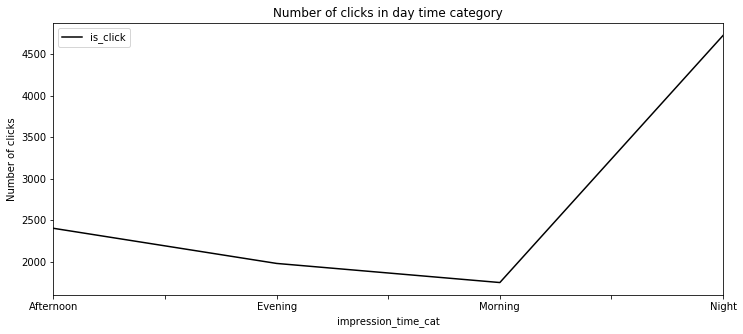

In [118]:
data.groupby(['impression_time_cat']).agg({'is_click':'sum'}).plot(figsize=(12,5),color='black')
plt.ylabel('Number of clicks')
plt.title('Number of clicks in day time category')

Text(0.5, 1.0, 'Number of clicks in days')

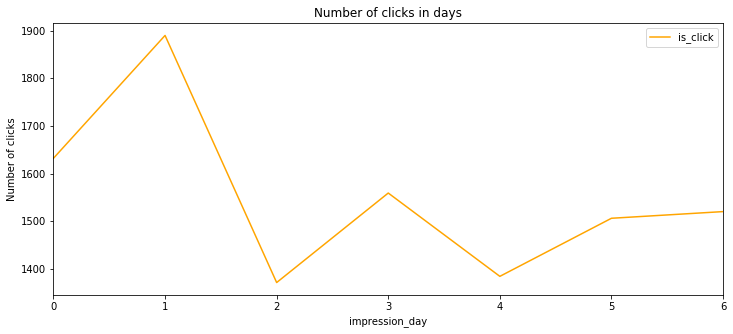

In [119]:
data.groupby(['impression_day']).agg({'is_click':'sum'}).plot(figsize=(12,5),color='orange')
plt.ylabel('Number of clicks')
plt.title('Number of clicks in days')

In [120]:
#Dropping impression hour
data.drop(['impression_hour'],axis=1,inplace=True)

test.drop(['impression_hour'],axis=1,inplace=True)

### Merging all the files

In [121]:
#Preaparing the training files
merge_df1=pd.merge(data,log_val,on=['user_id'])
merge_df2=pd.merge(merge_df1,item_val,on=['user_id'])
merge_df2.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,impression_day,impression_time_cat,Total_sessions_per_user,...,category_2_75_sum,category_2_75_mean,category_2_76_sum,category_2_76_mean,category_2_77_sum,category_2_77_mean,category_2_78_sum,category_2_78_mean,category_2_79_sum,category_2_79_mean
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,3,Night,1,...,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0
1,621bf66ddb7c962aa0d22ac97d69b793,2018-11-15 00:19:00,87862,422,old,0,0,3,Night,1,...,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0
2,ab394288aed46588bdc90bf4b541ec0d,2018-11-16 17:29:00,87862,422,old,0,0,4,Evening,1,...,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0
3,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,3,Night,7,...,0,0.0,1,0.083333,0,0.0,0,0.0,0,0.0
4,6b18886bc278247582704943f5c66eb9,2018-11-16 16:31:00,63410,467,latest,1,0,4,Afternoon,7,...,0,0.0,1,0.083333,0,0.0,0,0.0,0,0.0


In [122]:
merge_df2.shape

(237606, 210)

### Transforming Variables

In [123]:
#Dropping unnecessary variables
df_sel=merge_df2.drop(['impression_time','user_id','app_code'],axis=1)

In [124]:
df_sel_1=pd.get_dummies(df_sel,columns=['os_version','impression_day','impression_time_cat','device_type'],prefix='cat_',drop_first=True)
df_sel_new=pd.get_dummies(df_sel_1,columns=['is_4G'],prefix='4G_',drop_first=True)

In [126]:
df_sel_new.shape

(237606, 215)

### Saving Train File 

In [127]:
train_df=df_sel_new.to_csv('train_new.csv',index=False)

In [131]:
df_sel_new.isnull().sum().to_csv('columns.csv')

### H20 AutoML

In [132]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Thatoi\AppData\Local\Temp\tmp9w53lp31
  JVM stdout: C:\Users\Thatoi\AppData\Local\Temp\tmp9w53lp31\h2o_Thatoi_started_from_python.out
  JVM stderr: C:\Users\Thatoi\AppData\Local\Temp\tmp9w53lp31\h2o_Thatoi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 6 months and 16 days !!!"
H2O cluster name:,H2O_from_python_Thatoi_meuxbu
H2O cluster total nodes:,1
H2O cluster free memory:,1.547 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [133]:
train=h2o.import_file('train_new.csv')
#test=h2o.import_file('test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [134]:
y='is_click'
x=[ 'Total_sessions_per_user',
 'Total_items_per_session_per_user',
 'avg_duration_per_user',
 'Total_items_per_user',
 'Total_category1_items',
 'Total_category2_items',
 'Total_category3_items',
 'Total_products',
 'Total_item_price',
 'Avg_price_per_cat1',
 'Avg_price_per_cat2',
 'Avg_price_per_cat3',
 'category_1_1_sum',
 'category_1_1_mean',
 'category_1_2_sum',
 'category_1_2_mean',
 'category_1_4_sum',
 'category_1_4_mean',
 'category_1_5_sum',
 'category_1_5_mean',
 'category_1_6_sum',
 'category_1_6_mean',
 'category_1_7_sum',
 'category_1_7_mean',
 'category_1_8_sum',
 'category_1_8_mean',
 'category_1_9_sum',
 'category_1_9_mean',
 'category_1_10_sum',
 'category_1_10_mean',
 'category_1_11_sum',
 'category_1_11_mean',
 'category_1_12_sum',
 'category_1_12_mean',
 'category_1_13_sum',
 'category_1_13_mean',
 'category_1_14_sum',
 'category_1_14_mean',
 'category_1_15_sum',
 'category_1_15_mean',
 'category_1_16_sum',
 'category_1_16_mean',
 'category_1_17_sum',
 'category_1_17_mean',
 'category_2_1_sum',
 'category_2_1_mean',
 'category_2_2_sum',
 'category_2_2_mean',
 'category_2_3_sum',
 'category_2_3_mean',
 'category_2_4_sum',
 'category_2_4_mean',
 'category_2_5_sum',
 'category_2_5_mean',
 'category_2_6_sum',
 'category_2_6_mean',
 'category_2_7_sum',
 'category_2_7_mean',
 'category_2_8_sum',
 'category_2_8_mean',
 'category_2_9_sum',
 'category_2_9_mean',
 'category_2_10_sum',
 'category_2_10_mean',
 'category_2_11_sum',
 'category_2_11_mean',
 'category_2_12_sum',
 'category_2_12_mean',
 'category_2_13_sum',
 'category_2_13_mean',
 'category_2_14_sum',
 'category_2_14_mean',
 'category_2_15_sum',
 'category_2_15_mean',
 'category_2_16_sum',
 'category_2_16_mean',
 'category_2_17_sum',
 'category_2_17_mean',
 'category_2_18_sum',
 'category_2_18_mean',
 'category_2_19_sum',
 'category_2_19_mean',
 'category_2_20_sum',
 'category_2_20_mean',
 'category_2_21_sum',
 'category_2_21_mean',
 'category_2_22_sum',
 'category_2_22_mean',
 'category_2_23_sum',
 'category_2_23_mean',
 'category_2_24_sum',
 'category_2_24_mean',
 'category_2_25_sum',
 'category_2_25_mean',
 'category_2_26_sum',
 'category_2_26_mean',
 'category_2_27_sum',
 'category_2_27_mean',
 'category_2_28_sum',
 'category_2_28_mean',
 'category_2_29_sum',
 'category_2_29_mean',
 'category_2_30_sum',
 'category_2_30_mean',
 'category_2_31_sum',
 'category_2_31_mean',
 'category_2_33_sum',
 'category_2_33_mean',
 'category_2_34_sum',
 'category_2_34_mean',
 'category_2_35_sum',
 'category_2_35_mean',
 'category_2_36_sum',
 'category_2_36_mean',
 'category_2_37_sum',
 'category_2_37_mean',
 'category_2_38_sum',
 'category_2_38_mean',
 'category_2_39_sum',
 'category_2_39_mean',
 'category_2_40_sum',
 'category_2_40_mean',
 'category_2_41_sum',
 'category_2_41_mean',
 'category_2_42_sum',
 'category_2_42_mean',
 'category_2_43_sum',
 'category_2_43_mean',
 'category_2_44_sum',
 'category_2_44_mean',
 'category_2_45_sum',
 'category_2_45_mean',
 'category_2_46_sum',
 'category_2_46_mean',
 'category_2_47_sum',
 'category_2_47_mean',
 'category_2_48_sum',
 'category_2_48_mean',
 'category_2_49_sum',
 'category_2_49_mean',
 'category_2_50_sum',
 'category_2_50_mean',
 'category_2_51_sum',
 'category_2_51_mean',
 'category_2_52_sum',
 'category_2_52_mean',
 'category_2_53_sum',
 'category_2_53_mean',
 'category_2_54_sum',
 'category_2_54_mean',
 'category_2_55_sum',
 'category_2_55_mean',
 'category_2_56_sum',
 'category_2_56_mean',
 'category_2_57_sum',
 'category_2_57_mean',
 'category_2_58_sum',
 'category_2_58_mean',
 'category_2_59_sum',
 'category_2_59_mean',
 'category_2_60_sum',
 'category_2_60_mean',
 'category_2_61_sum',
 'category_2_61_mean',
 'category_2_62_sum',
 'category_2_62_mean',
 'category_2_63_sum',
 'category_2_63_mean',
 'category_2_64_sum',
 'category_2_64_mean',
 'category_2_65_sum',
 'category_2_65_mean',
 'category_2_66_sum',
 'category_2_66_mean',
 'category_2_67_sum',
 'category_2_67_mean',
 'category_2_68_sum',
 'category_2_68_mean',
 'category_2_69_sum',
 'category_2_69_mean',
 'category_2_70_sum',
 'category_2_70_mean',
 'category_2_71_sum',
 'category_2_71_mean',
 'category_2_72_sum',
 'category_2_72_mean',
 'category_2_73_sum',
 'category_2_73_mean',
 'category_2_74_sum',
 'category_2_74_mean',
 'category_2_75_sum',
 'category_2_75_mean',
 'category_2_76_sum',
 'category_2_76_mean',
 'category_2_77_sum',
 'category_2_77_mean',
 'category_2_78_sum',
 'category_2_78_mean',
 'category_2_79_sum',
 'category_2_79_mean',
 'cat__latest',
 'cat__old',
 'cat__1',
 'cat__2',
 'cat__3',
 'cat__4',
 'cat__5',
 'cat__6',
 'cat__Evening',
 'cat__Morning',
 'cat__Night',
 'cat__iphone',
 '4G__1'
]
train[y]=train[y].asfactor()

In [135]:
aml = H2OAutoML(max_models = 30, max_runtime_secs=300, seed = 1)
aml.train(x = x, y = y, training_frame = train)
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows) # Entire leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


model_id,auc,logloss
DRF_0_AutoML_20190905_182432,0.637991,0.17955
StackedEnsemble_AllModels_0_AutoML_20190905_182432,0.63746,0.181438
StackedEnsemble_BestOfFamily_0_AutoML_20190905_182432,0.63746,0.181438
XRT_0_AutoML_20190905_182432,0.58723,0.223726
